In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler_poise
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
import random
random.seed(30)

importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


**In this code, I will create two datasets of one dimensional gaussian. Pass it through POISE-VAE setup and see 
if I can learn true latent space**

In [2]:
def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)

**Synthetic dataset**
The mean and variance of the two datasets is given by
<span class="math display">
    \begin{aligned}
    \mu_1&=1\\
    \sigma_1 &=1
    \end{aligned}
</span>
<span class="math display">
    \begin{aligned}
    \mu_2&=2\\
    \sigma_2 &=2
    \end{aligned}
</span>


In [3]:
## Creating synthetic datasets
nb_samples=5000
mu1  =torch.tensor(1.)   # . converts long to float
var1 =torch.tensor(1.0)
mu2  =torch.tensor(2.)   # . converts long to float
var2 =torch.tensor(2.0)

inp_data1=sample(mu1,var1,nb_samples)  
inp_data1=inp_data1.unsqueeze(0)+torch.randn_like(inp_data1)##Adding gaussian noise to data
inp_data1=torch.transpose(inp_data1,0,1)

inp_data2=sample(mu2,var2,nb_samples)
inp_data2=inp_data2.unsqueeze(0)+torch.randn_like(inp_data2)  ##Adding gaussian noise to data
inp_data2=torch.transpose(inp_data2,0,1)

In [4]:
torch.randn_like(inp_data2).size()

torch.Size([5000, 1])

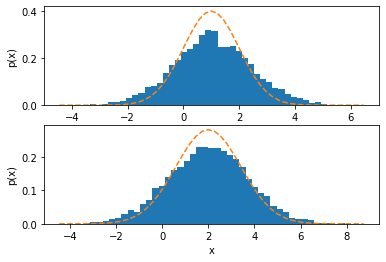

mu1 tensor(1.)
var1 tensor(1.)
mu2 tensor(2.)
var2 tensor(2.)


In [5]:
## for data visualization
data_vis1=inp_data1.numpy()
data_vis2=inp_data2.numpy()
fig, ax = plt.subplots(2,1)
#flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
#Panel a
n1,bins1,patches1=ax[0].hist(data_vis1,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
ax[0].plot(bins1,y1,'--')
ax[0].set(xlabel='x',ylabel='p(x)')
#Panel b
n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
y2=1/(np.sqrt(2*np.pi*var2))*np.exp(-0.5*(bins2-mu2.numpy())**2/var2)
ax[1].plot(bins2,y2,'--')
ax[1].set(xlabel='x',ylabel='p(x)')
plt.show()
print("mu1",mu1)
print("var1",var1)
print("mu2",mu2)
print("var2",var2)

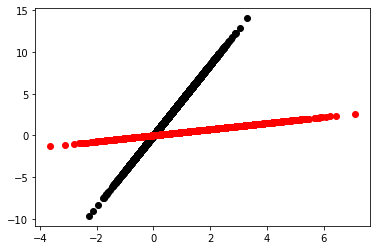

In [6]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data1    = inp_data1*fun_A1
data2    = inp_data2*fun_A2
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [7]:
## Hyperparameters
epochs     = 500
batch_size = 128
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
## Creating synthetic dataloader

train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

My neural network has the following architecture:
Encoder for the two modalities looks like:
<span class="math display">
    \begin{aligned}
    x_1=Ax_1+b\\
    z_1=Bx_1+b_2\\
    x_2=A'x_2+b'\\
    z_2=Bx_2+b_2
    \end{aligned}
</span>
The output of the two encoders are:
<span class="math display">
    \begin{aligned}
    \lambda_1&=z_1(0)\\
    \lambda_2&=-\mathrm{exp}(z_1(1))\\
    \lambda'_1&=z_2(0)\\
    \lambda'_2&=-\mathrm{exp}(z_2(1))
    \end{aligned}
</span>
The output of encoder is fed to Gibbs sampler function. The output of Gibbs sampler is fed to the decoder. The equation for the each of the decoders is given by:
<span class="math display">
    \begin{aligned}
    x_1=Cz_1
    \end{aligned}
</span>

In [9]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)

latent_dim1 = 1
latent_dim2 = 1
        
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler()  
        self.kl_div                  = kl_divergence_calculator.kl_divergence()
        ## Encoder set1
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1)
        ## Encoder set2
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim2)
        self.set2_enc2 = nn.Linear(in_features = 2*latent_dim2,out_features = 2*latent_dim2)
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = dim_exp,bias=False)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim1)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)

    def forward(self,x1,x2):
        data1    = x1
        data2    = x2
        ## encoding
# Modality 1
        x1       = self.set1_enc1(x1)
        x1       = self.set1_enc2(x1)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        log_var1 = log_var1.unsqueeze(0)
        log_var1 = torch.transpose(log_var1,0,1)    
        var1     = -torch.exp(log_var1)         # lambda_2<0
# Modality 2        
        x2       = self.set2_enc1(x2)
        x2       = self.set2_enc2(x2)        
        mu2      = x2[:,0]
        mu2      = mu2.unsqueeze(0)
        mu2      = torch.transpose(mu2,0,1)    
        log_var2 = x2[:,1]
        log_var2 = log_var2.unsqueeze(0)
        log_var2 = torch.transpose(log_var2,0,1) 
        var2     = -torch.exp(log_var2)           #lambdap_2<0
        g22      = -torch.exp(self.g22)     
        g11_copy = self.g11.detach()
        g22_copy = g22.detach()
        mu1_copy = mu1.detach()
        mu2_copy = mu2.detach()
        var1_copy=var1.detach()
        var2_copy=var2.detach()      
        if self.flag_initialize==1:
            z1_prior,z2_prior = self.gibbs.initialize_prior_sample(g11_copy,g22_copy)
            self.flag_initialize=0
            z1_posterior,z2_posterior = self.gibbs.initialize_posterior_sample(g11_copy,g22_copy,mu1_copy,var1_copy,mu2_copy,var2_copy)
            self.z1_prior =z1_prior
            self.z2_prior =z2_prior
            self.z1_posterior=z1_posterior
            self.z2_posterior=z2_posterior
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.prior_sample(z1_prior,z2_prior,self.g11,g22)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.posterior_sample(z1_posterior,z2_posterior,self.g11,g22,mu1,var1,mu2,var2)
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
         ## decoding

        reconstruction1=self.set1_dec1(self.z1_gibbs_posterior)
        reconstruction2=self.set2_dec1(self.z2_gibbs_posterior)
        ## loss
        mse_loss = nn.MSELoss(reduction='sum')
        MSE1     = mse_loss(reconstruction1, data1)
        MSE2     = mse_loss(reconstruction2, data2)
#         print(part_fun0)
#         print(part_fun1)
#         print(part_fun2)
        KLD      = part_fun0+part_fun1+part_fun2
        loss     = MSE1+MSE2+KLD
        if self.flag_initialize==0:
#             make_dot(part_fun0,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun0", format="png")
#             make_dot(part_fun1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun1", format="png")
#             make_dot(part_fun2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun2", format="png")
#             make_dot(MSE1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE1", format="png")
#             make_dot(MSE2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE2", format="png")
#             make_dot(self.z1_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_prior", format="png")
#             make_dot(self.z2_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_prior", format="png")
#             make_dot(self.z1_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_posterior", format="png")
#             make_dot(self.z2_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior", format="png")
            
            self.flag_initialize=5
        return reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss

In [10]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set1_dec1.weight
set2_dec1.weight


In [11]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)   
        optimizer.zero_grad()
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data1,data2)     
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
#         for p in model.parameters():
#             print(p.grad.norm())
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)        
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)

    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [12]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set2)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    
#     for name, para in model.named_parameters():
#         print(para)
    print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

Epoch 1 of 500
Train Loss    : 10.3957
Epoch 2 of 500
Train Loss    : 10.3793
Epoch 3 of 500
Train Loss    : 10.3433
Epoch 4 of 500
Train Loss    : 10.3685
Epoch 5 of 500
Train Loss    : 10.3545
Epoch 6 of 500
Train Loss    : 10.3647
Epoch 7 of 500
Train Loss    : 10.3535
Epoch 8 of 500
Train Loss    : 10.3425
Epoch 9 of 500
Train Loss    : 10.3081
Epoch 10 of 500
Train Loss    : 10.3159
Epoch 11 of 500
Train Loss    : 10.2808
Epoch 12 of 500
Train Loss    : 10.3066
Epoch 13 of 500
Train Loss    : 10.2661
Epoch 14 of 500
Train Loss    : 10.2278
Epoch 15 of 500
Train Loss    : 10.2406
Epoch 16 of 500
Train Loss    : 10.2316
Epoch 17 of 500
Train Loss    : 10.2042
Epoch 18 of 500
Train Loss    : 10.2067
Epoch 19 of 500
Train Loss    : 10.1797
Epoch 20 of 500
Train Loss    : 10.1675
Epoch 21 of 500
Train Loss    : 10.1516
Epoch 22 of 500
Train Loss    : 10.1427
Epoch 23 of 500
Train Loss    : 10.1257
Epoch 24 of 500
Train Loss    : 10.1067
Epoch 25 of 500
Train Loss    : 10.0686
Epoch 26 

KeyboardInterrupt: 

In [23]:
data2_val.size()

torch.Size([896, 2])

In [64]:
for name, para in model.named_parameters():
    print(para)

Parameter containing:
tensor([[1.9044]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.6192]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1040, -0.5550],
        [-0.7399, -0.2328]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1390, 0.0624], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1973, -0.4548],
        [ 0.4031,  0.0588]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.9515, -0.1036], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.4853, -0.4528],
        [ 1.0021, -0.0596]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.3103, -0.2371], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.5641, -0.7142],
        [-0.1938,  1.1339]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.2565, 0.1507], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.6715],

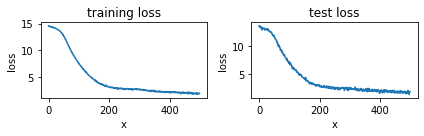

In [17]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

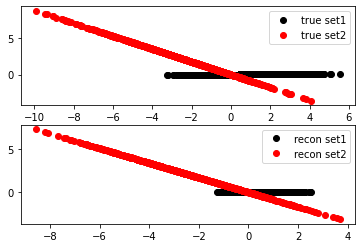

In [18]:
reconstruction1_x_cord = reconstruction1_pred[:,0].cpu().detach().numpy()
reconstruction1_y_cord = reconstruction1_pred[:,1].cpu().detach().numpy()
reconstruction2_x_cord = reconstruction2_pred[:,0].cpu().detach().numpy()
reconstruction2_y_cord = reconstruction2_pred[:,1].cpu().detach().numpy()
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
data2_x_cord = data2_val[:,0].cpu().detach().numpy()
data2_y_cord = data2_val[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
ax[0].plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='black',label='recon set1')
ax[1].plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='red',label='recon set2')
ax[1].legend()
plt.show()

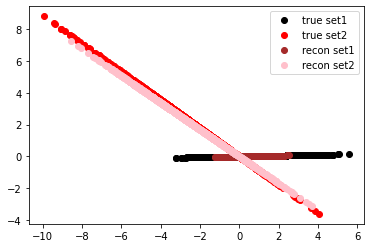

In [19]:
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='pink',label='recon set2')
plt.legend()
plt.show()

In [21]:
data1_x_cord

array([ 0.66795564, -0.74430674,  1.7791153 ,  6.5713077 , -0.4526054 ,
        4.5209465 ,  1.3799707 ,  0.16862889,  5.3608193 ,  2.3938112 ,
       -2.027011  ,  5.7542825 ,  1.5257907 ,  3.5365317 ,  0.6614436 ,
        3.0182889 , -0.9023155 ,  1.4078238 ,  4.412712  , -1.3677166 ,
        1.8917032 ,  5.6253686 ,  0.58121544,  2.913442  , -1.110309  ,
       -4.072115  ,  1.0657465 ,  4.24858   ,  2.7580144 , -1.306724  ,
       -2.277106  , -0.5097432 ,  2.8327472 ,  0.7120836 ,  3.3176584 ,
       -0.01087377, -1.0132254 , -1.4582324 ,  0.9188093 , -0.02471983,
        8.761314  ,  5.00742   ,  1.2378426 ,  4.232401  , -0.60521674,
        2.3281796 ,  1.716626  , -0.27733973,  3.2492356 ,  0.0576661 ,
        1.8251541 ,  0.40755364,  2.7696295 ,  1.8310826 ,  0.1879461 ,
       -0.34218076, -1.044699  ,  2.1995578 ,  1.8700035 , -3.4927282 ,
       -3.8908706 ,  6.1588097 , -3.903475  , -2.0092897 , -0.1694899 ,
        0.91571045,  3.3736875 ,  0.7140449 ,  1.6340891 ,  1.41

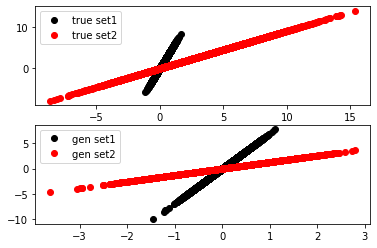

In [51]:
## Transforming data to a higher dimension
mean_pred  = torch.tensor(0.).cpu()   # . converts long to float
var_pred   = torch.tensor(1.0).cpu()
gen_data   = sample(mean_pred,var_pred,nb_samples)
gen_data   = gen_data.unsqueeze(1)

"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
#fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
param_dict={}
for name, para in model.named_parameters():
    param_dict[name]=para

A1=param_dict["set1_dec1.weight"]
A2=param_dict["set2_dec1.weight"]
set1_dec1_wgt=A1
set2_dec1_wgt=A2
set1_dec1_wgt  = (torch.transpose(set1_dec1_wgt,0,1)).cpu()
set2_dec1_wgt  = (torch.transpose(set2_dec1_wgt,0,1)).cpu()

data1_sim= gen_data*set1_dec1_wgt
data2_sim= gen_data*set2_dec1_wgt

dat1_x_cord = data1_sim[:,0].cpu().detach().numpy()
dat1_y_cord = data1_sim[:,1].cpu().detach().numpy()
dat2_x_cord = data2_sim[:,0].cpu().detach().numpy()
dat2_y_cord = data2_sim[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(x1_cord,y1_cord, 'o', color='black',label='true set1')
ax[0].plot(x2_cord,y2_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(dat1_x_cord,dat1_y_cord, 'o', color='black',label='gen set1')
ax[1].plot(dat2_x_cord,dat2_y_cord, 'o', color='red',label='gen set2')
ax[1].legend()
plt.show()

In [19]:
A= list(model.parameters())
A

[Parameter containing:
 tensor([[2.0768]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-2.4415]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.5008]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.7332, -1.0731],
         [ 2.1564,  1.4422]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.4124, 1.3495], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-1.5779, -1.8647],
         [ 0.2232, -0.0667]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-1.1530, -1.0212], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.2210, -0.2045],
         [ 1.0558,  0.0590]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.4018,  1.8833], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.4392,  2.6525],
         [ 0.0175, -1.7382]], device='cuda:0', requires_grad=True),
 Parameter

In [20]:
sample_dict={}
for name, para in model.named_parameters():
    sample_dict[name]=para

In [21]:
sample_dict["set1_enc1.weight"]

Parameter containing:
tensor([[-0.7332, -1.0731],
        [ 2.1564,  1.4422]], device='cuda:0', requires_grad=True)

In [22]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f9216528ac0>